Imports

In [1]:
# pip install xgboost lightgbm



In [25]:
import zipfile
import numpy as np
import pandas as pd 
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns


import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
from mlflow.exceptions import MlflowException


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
from xgboost import XGBRegressor
from xgboost import plot_importance


In [3]:
zip_path = 'Housing Price Regression.zip'

with zipfile.ZipFile(zip_path, 'r') as z:
    print(z.namelist())  # Lists all files inside the ZIP


['house_price_regression_dataset.csv']


Read In Data

In [4]:
# Assuming it contains a CSV file, read it directly
csv_filename = "house_price_regression_dataset.csv"  
with zipfile.ZipFile(zip_path, 'r') as z:
    with z.open(csv_filename) as f:
        df = pd.read_csv(f)

# Display the first few rows
df.head()

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.599637,0,5,2.623829e+05
1,4272,3,3,2016,4.753014,1,6,9.852609e+05
2,3592,1,2,2016,3.634823,0,9,7.779774e+05
3,966,1,2,1977,2.730667,1,8,2.296989e+05
4,4926,2,1,1993,4.699073,0,8,1.041741e+06


Print out Column Names

In [5]:
df.columns

Index(['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Year_Built',
       'Lot_Size', 'Garage_Size', 'Neighborhood_Quality', 'House_Price'],
      dtype='object')

Length and width of File

In [6]:
df.shape

(1000, 8)

Summary Statstics

In [7]:
df.describe()

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,2815.422000,2.990000,1.973000,1986.550000,2.778087,1.022000,5.615000,6.188610e+05
std,1255.514921,1.427564,0.820332,20.632916,1.297903,0.814973,2.887059,2.535681e+05
min,503.000000,1.000000,1.000000,1950.000000,0.506058,0.000000,1.000000,1.116269e+05
25%,1749.500000,2.000000,1.000000,1969.000000,1.665946,0.000000,3.000000,4.016482e+05
50%,2862.500000,3.000000,2.000000,1986.000000,2.809740,1.000000,6.000000,6.282673e+05
75%,3849.500000,4.000000,3.000000,2004.250000,3.923317,2.000000,8.000000,8.271413e+05
max,4999.000000,5.000000,3.000000,2022.000000,4.989303,2.000000,10.000000,1.108237e+06


Check for the presence of any nulls

In [8]:
df.isnull().values.any()

np.False_

Determine Field Data Types. Might need to convert types.

In [9]:
print(df.dtypes)

Square_Footage            int64
Num_Bedrooms              int64
Num_Bathrooms             int64
Year_Built                int64
Lot_Size                float64
Garage_Size               int64
Neighborhood_Quality      int64
House_Price             float64
dtype: object


In [10]:
target_column = "House_Price"

Plot all Predictor Variables to get Initial Look

`Square Footage` appears to be factor affecting House Price. Other Features seem to have less linear influence. Tree-based models (like Random Forest, XGBoost) do not require linear relationships.

Some features just don’t have much signal.

`Horizontal Bar` --> Indicates that there are only a few unique values and the model can't learn enough if there is not enough variation. Check the variance of fields: A variable can't be predictive of the target if it doesn’t vary much. 

`Shotgun Blast` ( Points scattered everywhere ) --> The feature has no predictive relationship to the target

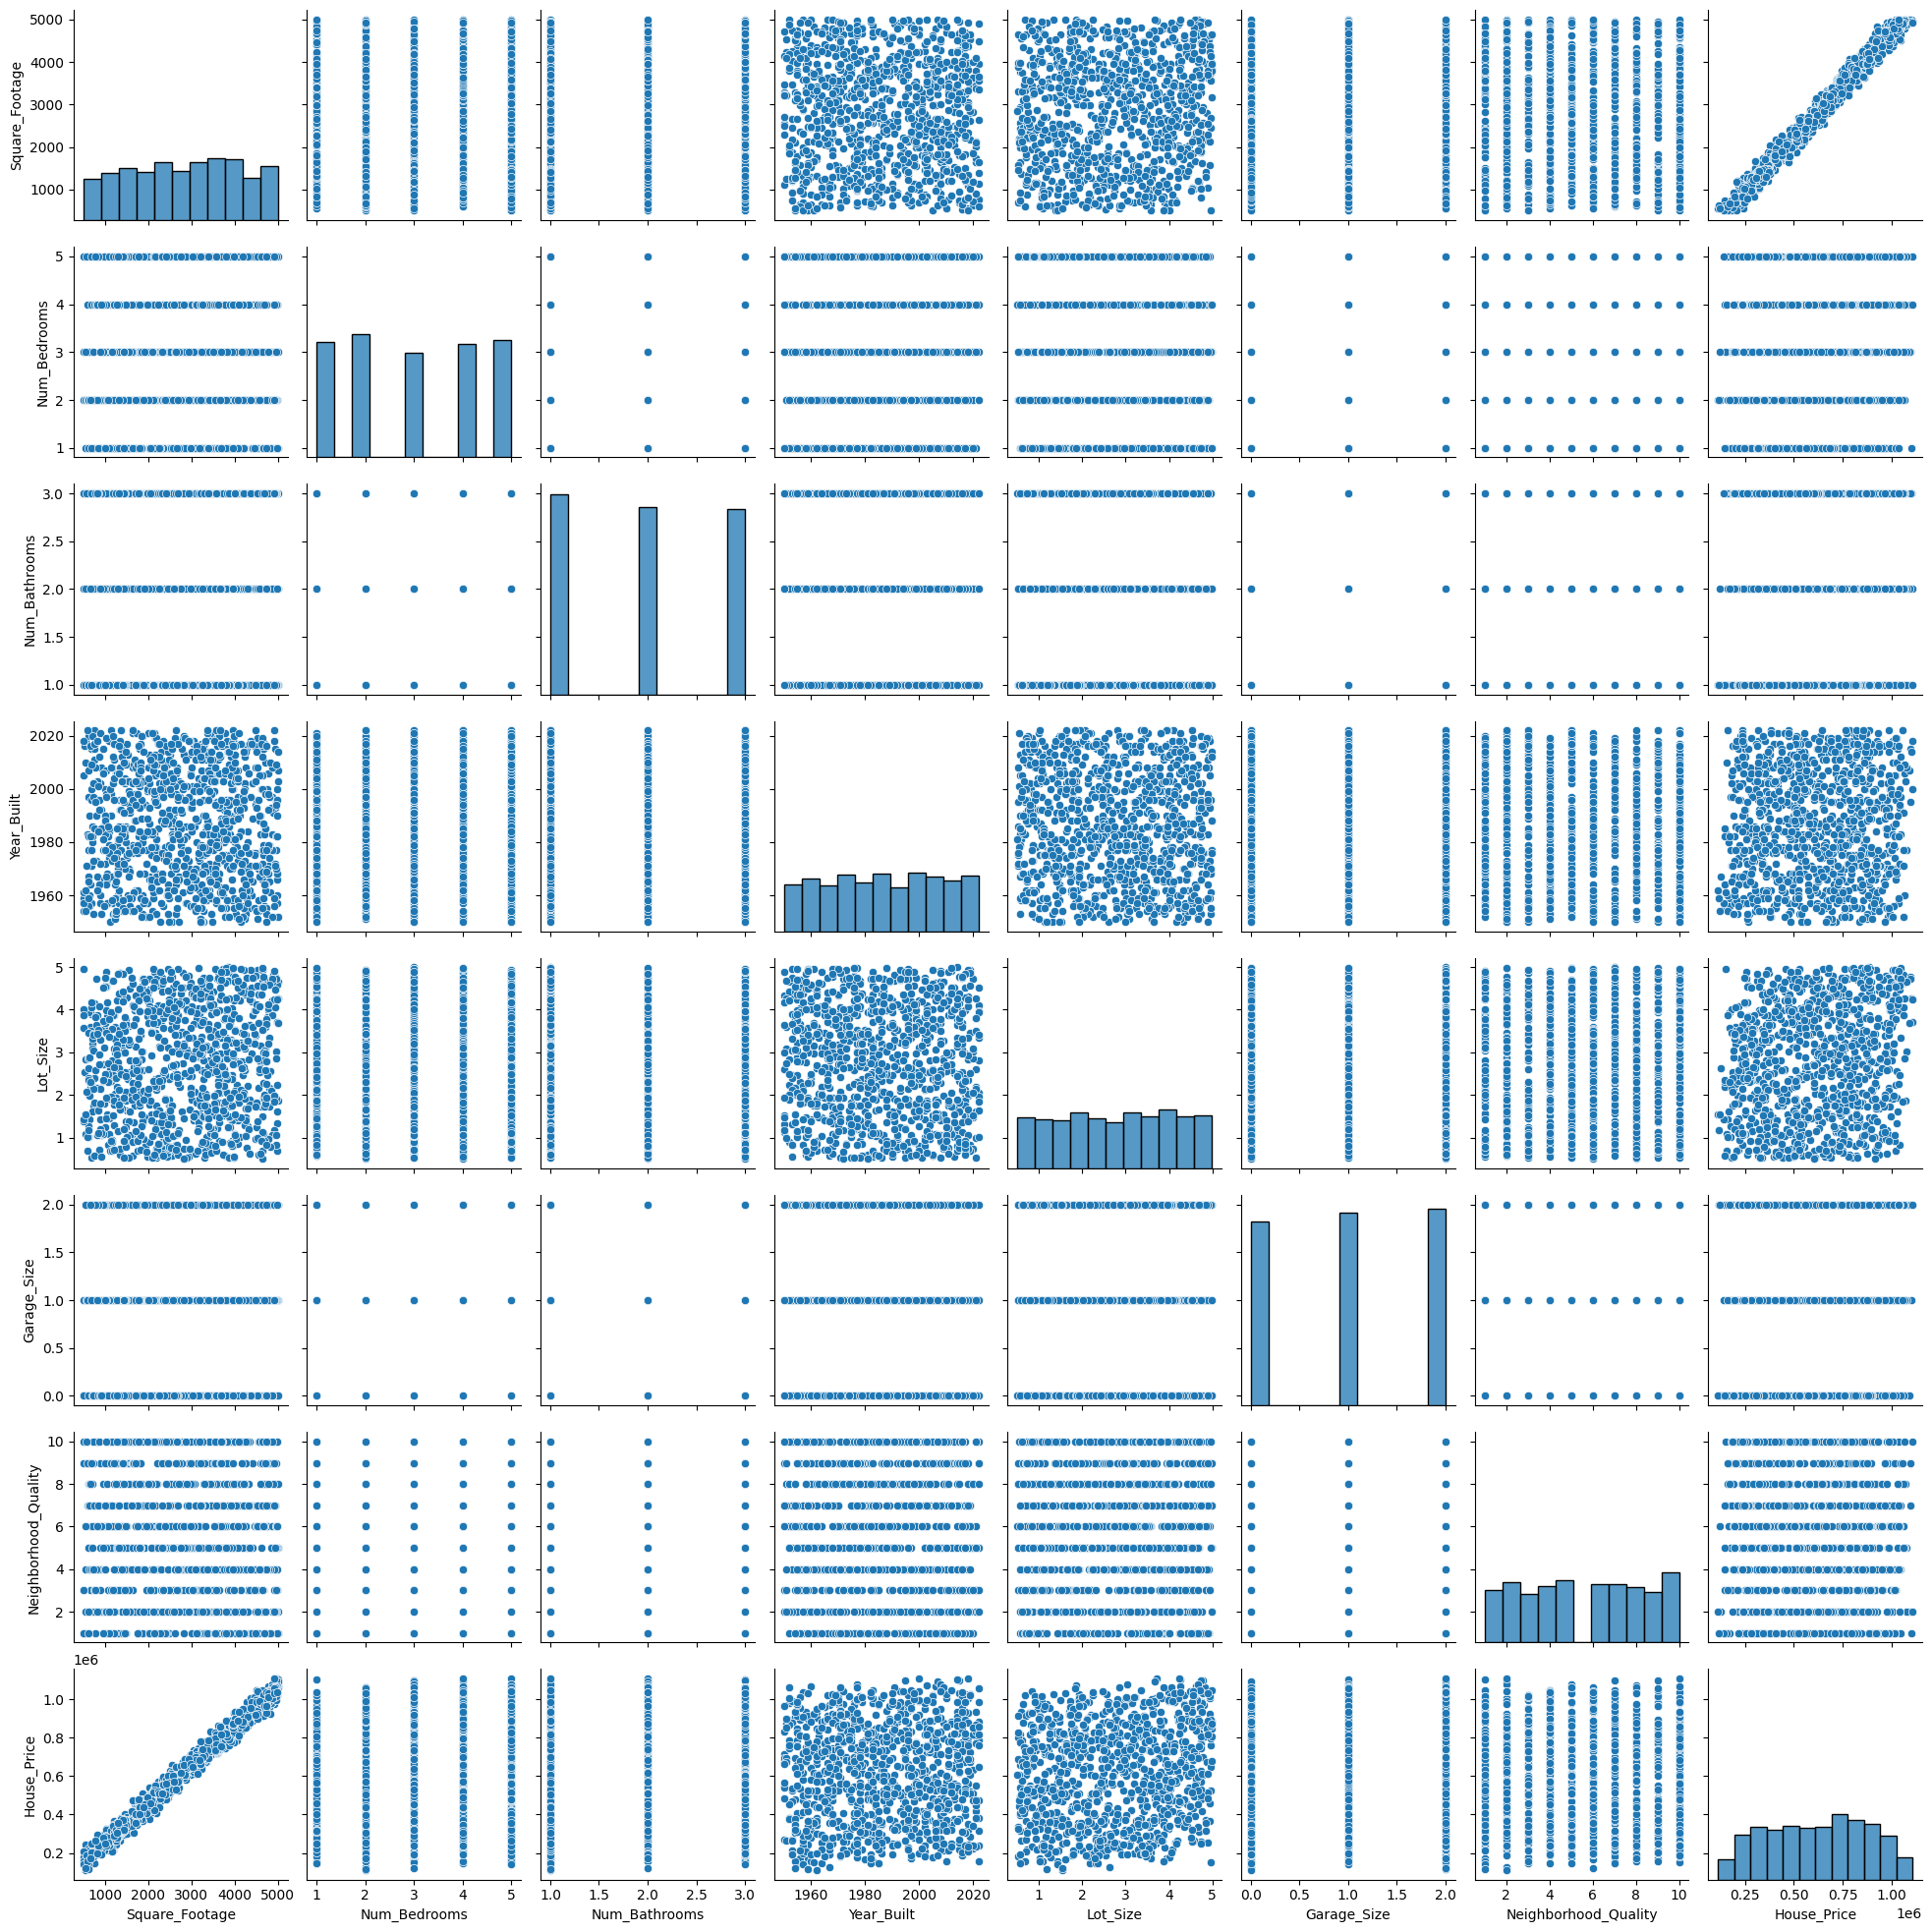

In [11]:
sns.pairplot(df)

Feature Engineering

In [12]:
# As a house with 5 Bedrooms and 1 Bath is not as desirable as 5 Bedrooms and 2+ baths
df['bath_bed_ratio'] = df['Num_Bathrooms']/df['Num_Bedrooms']

In [13]:
# A measure of the amount of available living space
# Assuming bedrooms and bathrooms are generally the same square footage

df['SqFt_per_LivingUnit'] = df['Square_Footage']/(df['Num_Bathrooms'] + df['Num_Bedrooms']+1e-3)

In [14]:
#Assuming that garage is NOT included in Square Footage.
#Unsure if this is plausible?

df['garage_per_1000_sqft'] = df['Garage_Size'] /(df['Square_Footage'] /1000)

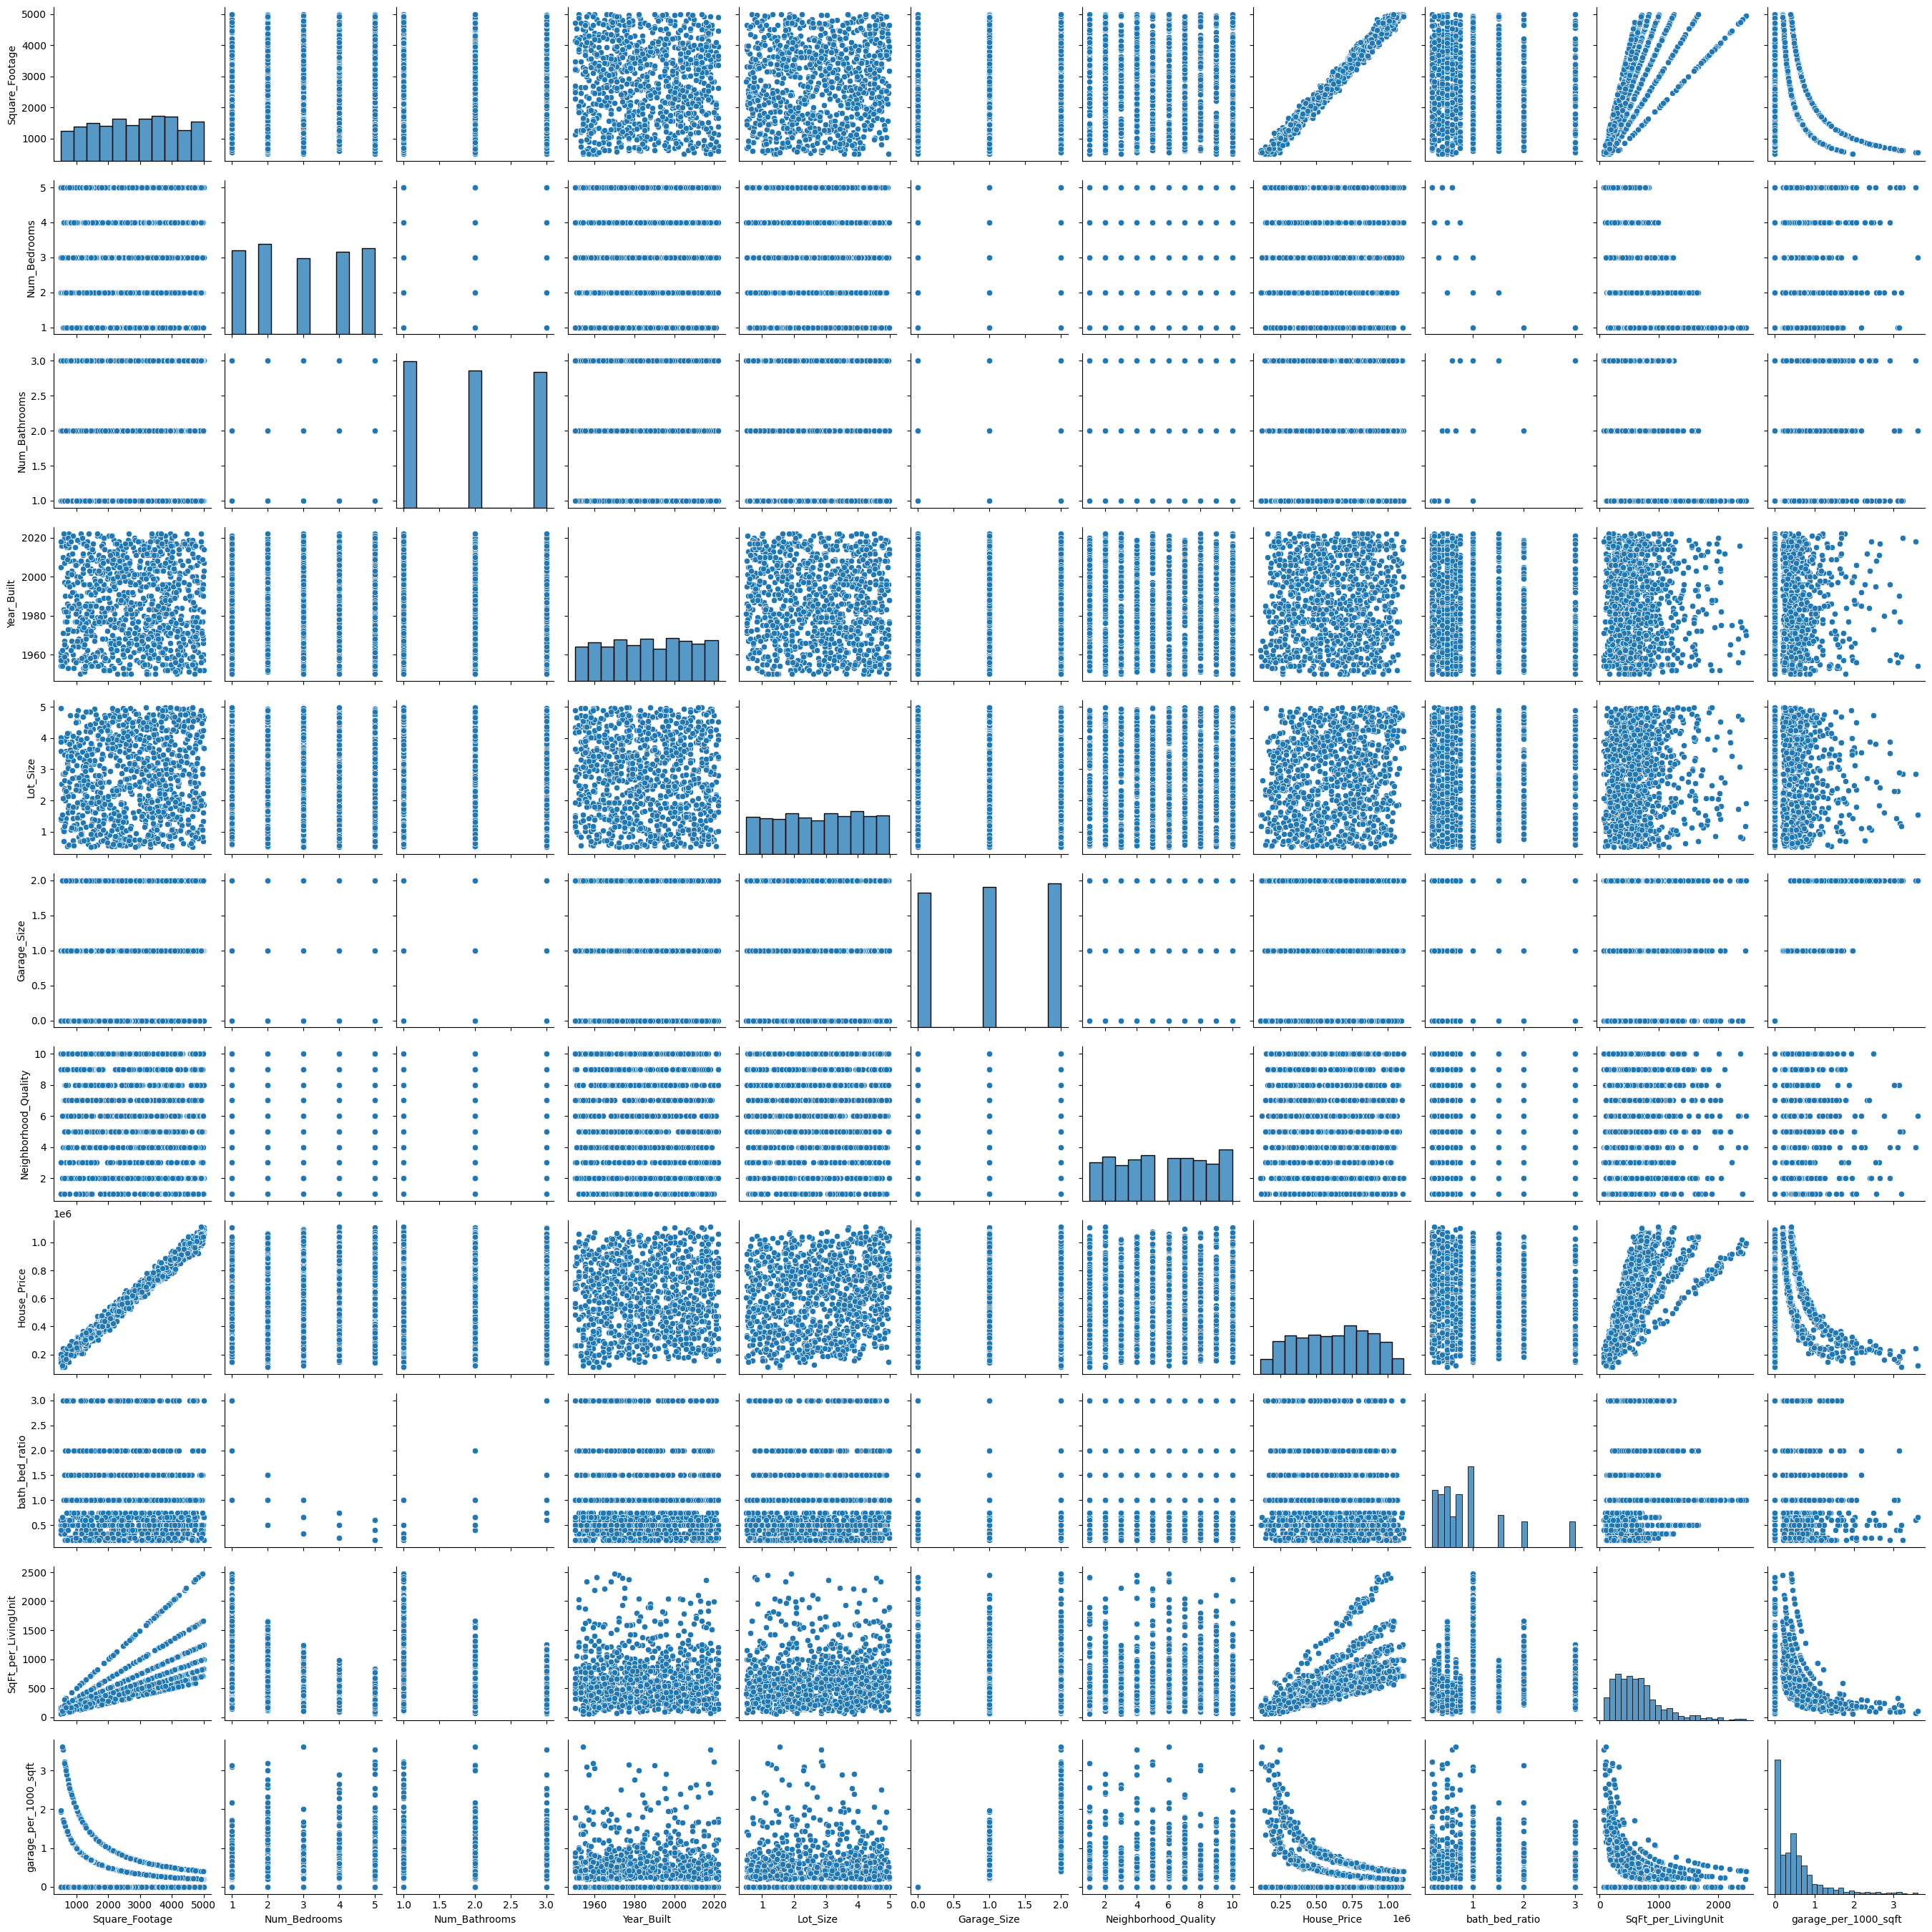

In [15]:
sns.pairplot(df)

In [16]:
for col in ['Num_Bedrooms', 'Num_Bathrooms', 'bath_bed_ratio','Garage_Size', 'Neighborhood_Quality','Lot_Size','Year_Built']:
    print(f"{col}: Unique values = {df[col].nunique()}, Value counts:\n{df[col].value_counts()}\n")

Num_Bedrooms: Unique values = 5, Value counts:
Num_Bedrooms
2    215
5    205
1    201
4    197
3    182
Name: count, dtype: int64

Num_Bathrooms: Unique values = 3, Value counts:
Num_Bathrooms
1    350
2    327
3    323
Name: count, dtype: int64

bath_bed_ratio: Unique values = 12, Value counts:
bath_bed_ratio
1.000000    193
0.500000    145
1.500000     77
0.600000     73
0.200000     69
0.666667     67
0.250000     67
0.333333     63
0.400000     63
2.000000     62
3.000000     62
0.750000     59
Name: count, dtype: int64

Garage_Size: Unique values = 3, Value counts:
Garage_Size
2    343
1    336
0    321
Name: count, dtype: int64

Neighborhood_Quality: Unique values = 10, Value counts:
Neighborhood_Quality
10    123
5     109
2     105
7     102
6     101
4      99
8      97
1      91
9      88
3      85
Name: count, dtype: int64

Lot_Size: Unique values = 1000, Value counts:
Lot_Size
3.108790    1
0.599637    1
4.753014    1
3.634823    1
2.730667    1
           ..
4.781489    1

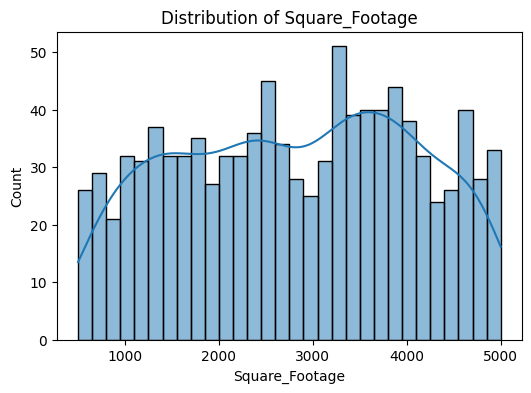

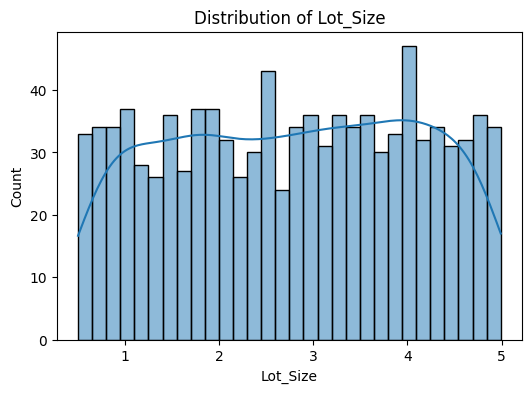

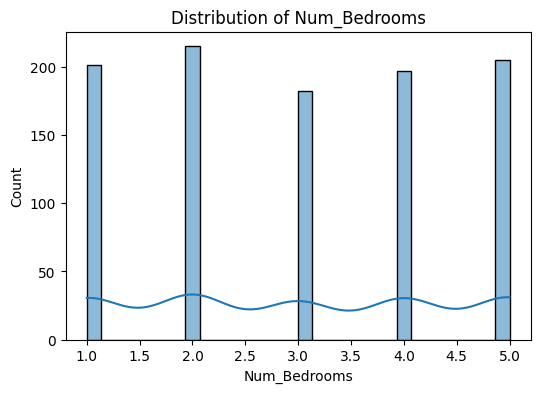

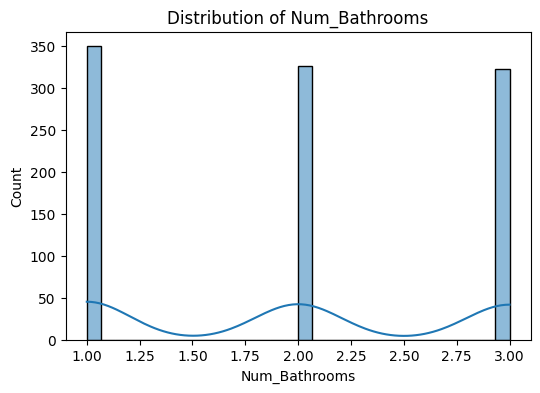

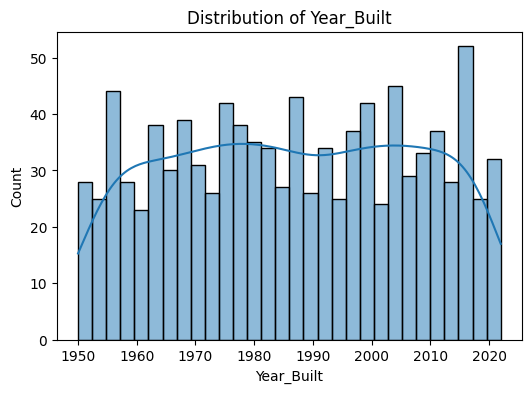

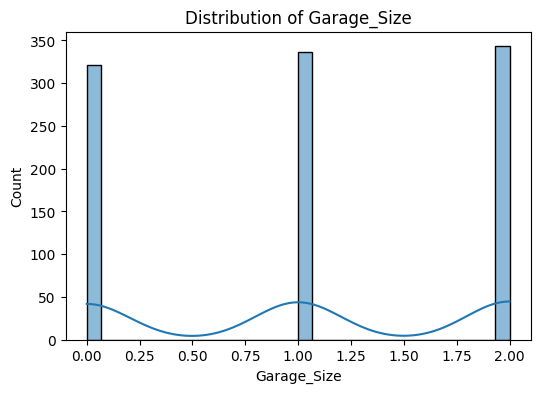

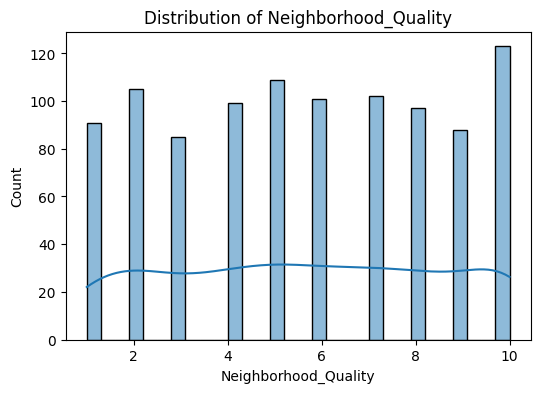

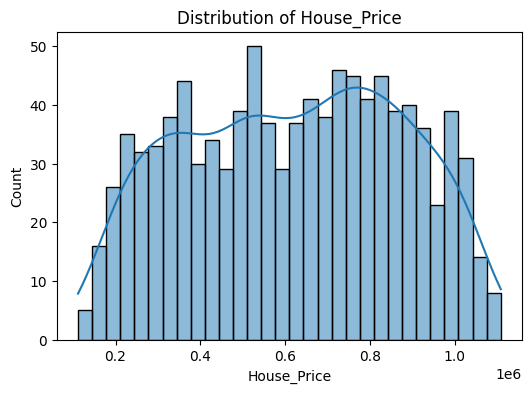

In [17]:

for col in ['Square_Footage', 'Lot_Size', 'Num_Bedrooms', 'Num_Bathrooms', 'Year_Built', 'Garage_Size', 'Neighborhood_Quality','House_Price',  ]:  
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()


Q-Q plots (Quantile-Quantile plot) to assess if your data is normally distributed *A key assumption in Linear Regression and other statistical models

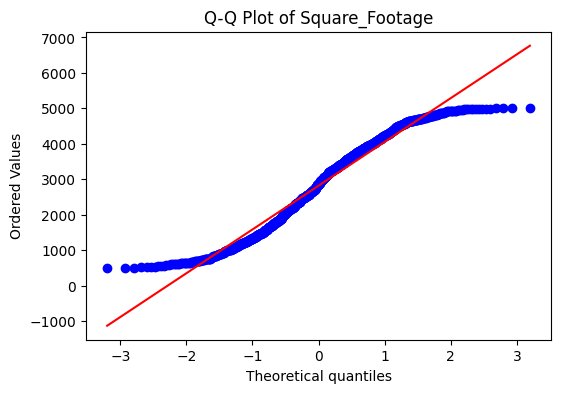

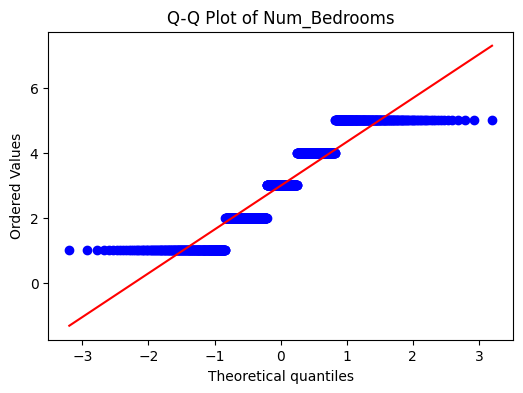

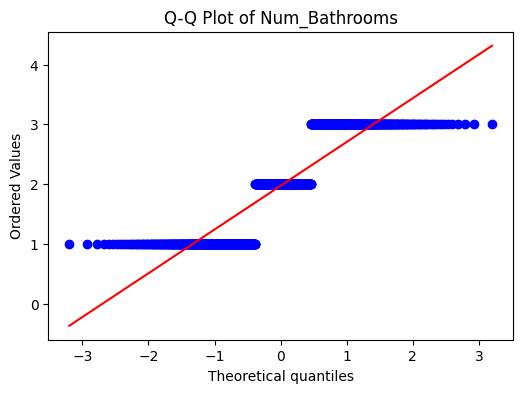

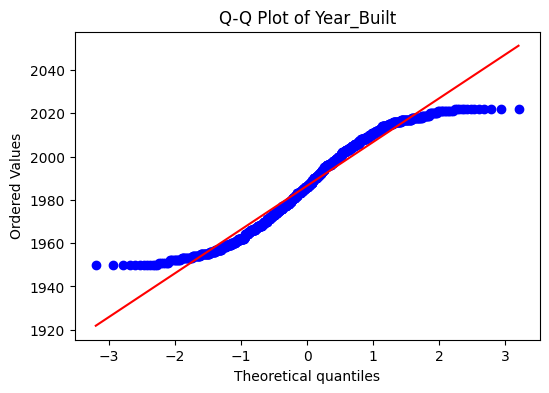

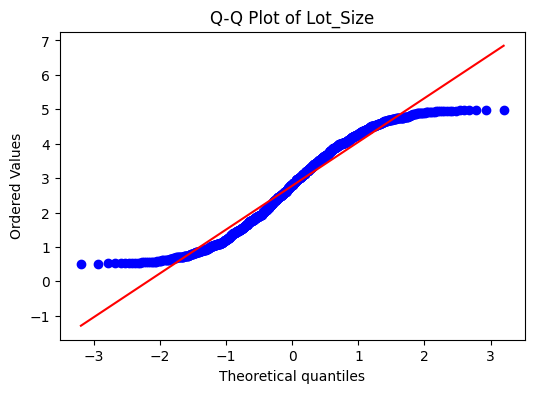

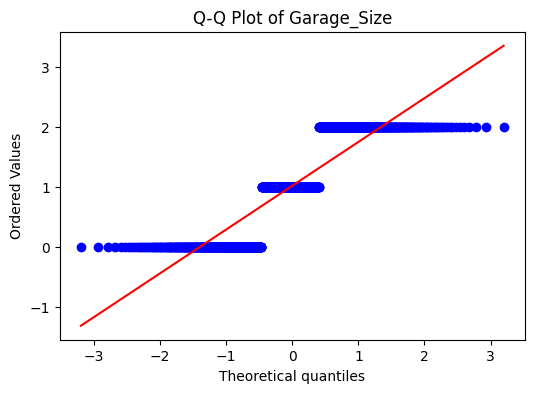

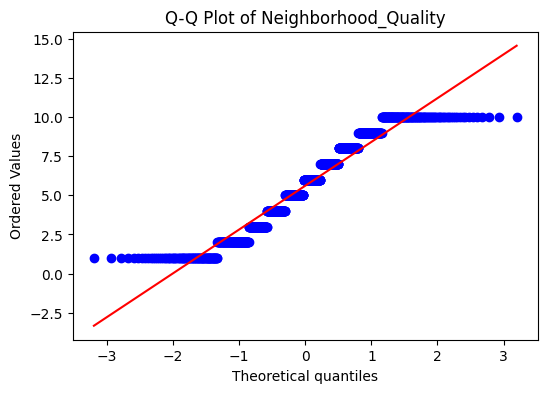

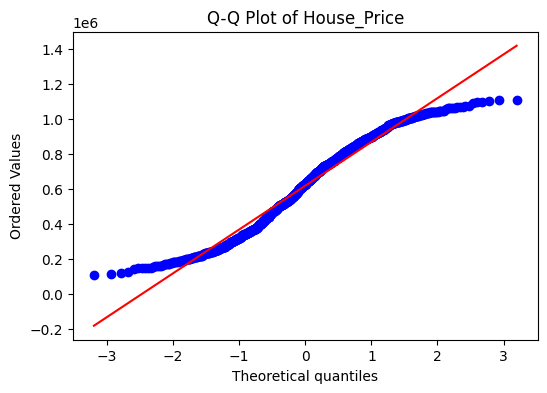

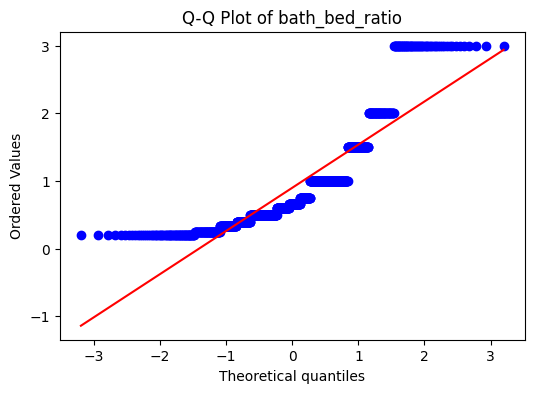

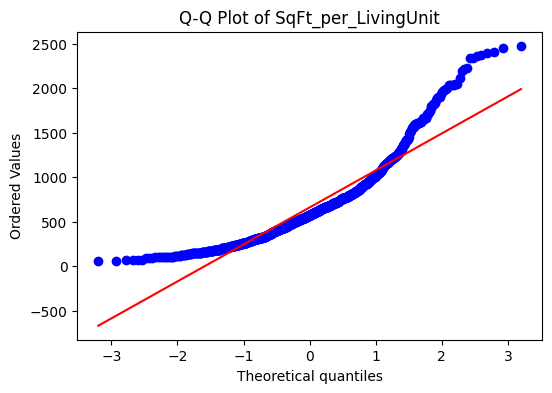

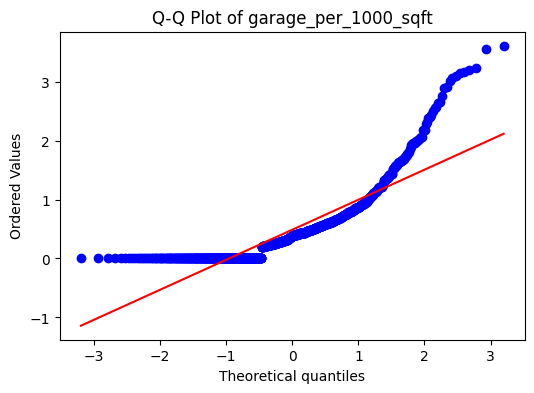

In [18]:
for col in df.columns:  # Loop through predictor variables
    plt.figure(figsize=(6, 4))
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {col}")
    plt.show()


Reviewing Correlations to House Price

In [19]:
df.corr()["House_Price"]

Square_Footage          0.991261
Num_Bedrooms            0.014633
Num_Bathrooms          -0.001862
Year_Built              0.051967
Lot_Size                0.160412
Garage_Size             0.052133
Neighborhood_Quality   -0.007770
House_Price             1.000000
bath_bed_ratio         -0.036567
SqFt_per_LivingUnit     0.652507
garage_per_1000_sqft   -0.466551
Name: House_Price, dtype: float64

Investigate Multicollinearity

If Square Footage is highly correlated with Bedrooms then this features might not contribute much independently.

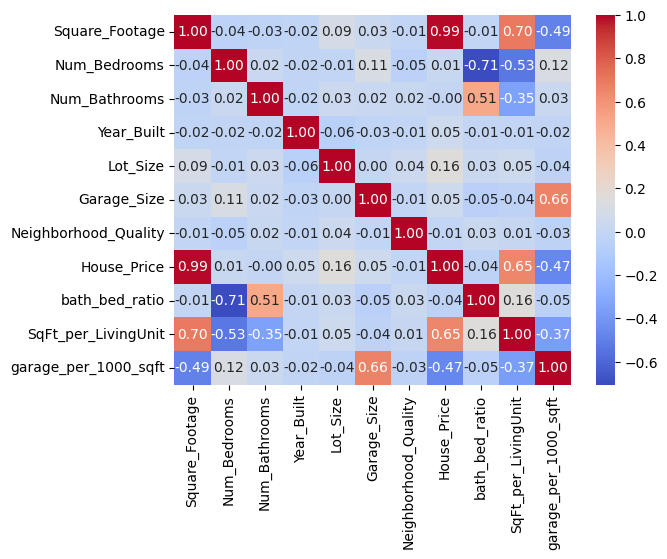

In [20]:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()


It would be nice to have features such as "Location" or "Condition"

Box Plots to Identify Outliers


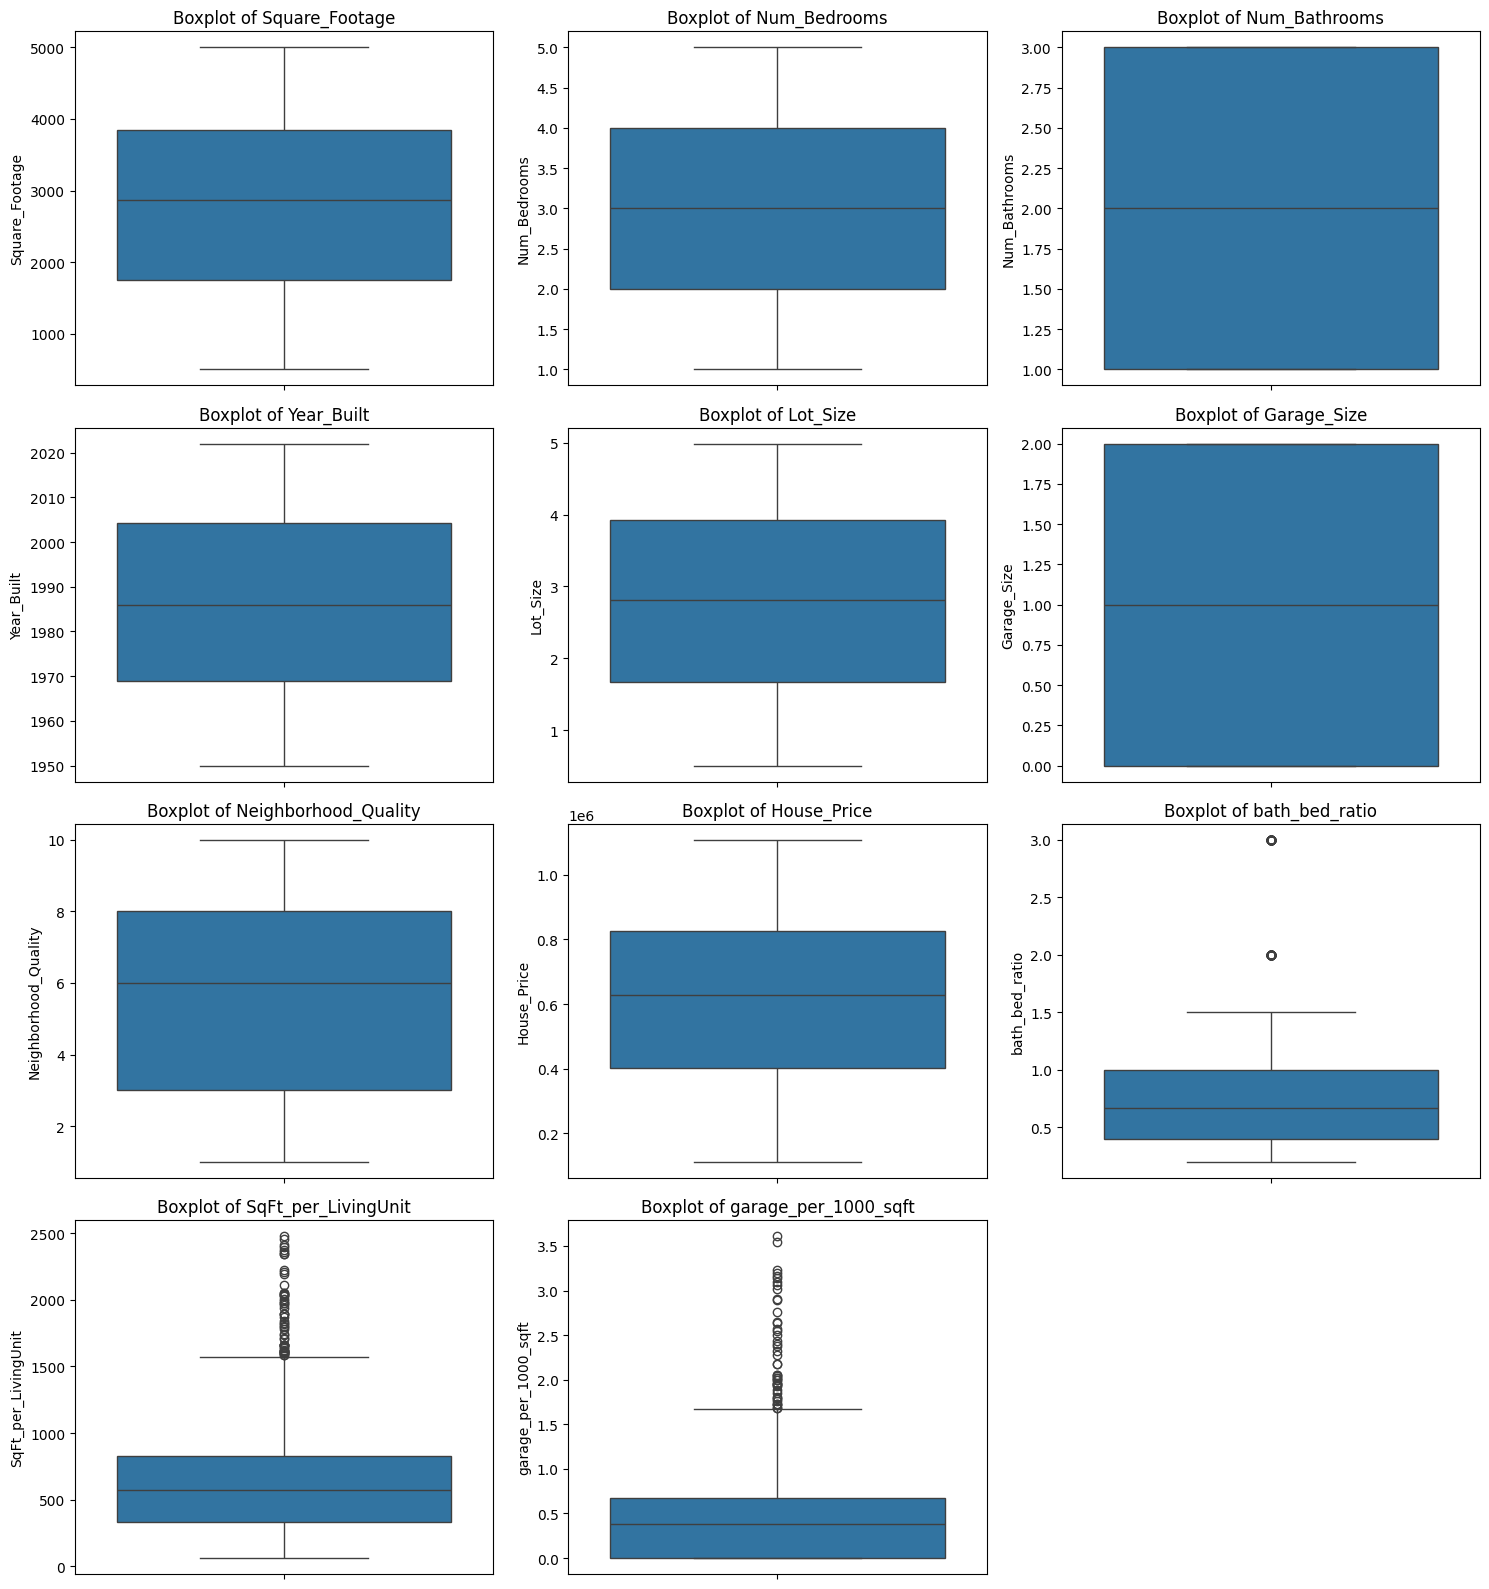

In [21]:
# Define the number of rows and columns for the grid layout
num_columns = 3  # Adjust based on preference
num_features = len(df.columns)
num_rows = int(np.ceil(num_features / num_columns))

# Create subplots for boxplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 4))
axes = axes.flatten()  # Flatten in case of fewer plots than grid spots

# Plot each feature separately in the grid
for i, col in enumerate(df.columns):
    sns.boxplot(y=df[col], ax=axes[i])  # Box plot for each variable
    axes[i].set_title(f"Boxplot of {col}")

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

`START OF MODELLING`

Using `Linear Regression` as a Baseline model.

Can more complex beat this? --> Occam's razor-->
Quantify the Power of One Good Feature
How much of the variance in price can Square_Footage alone explain?"

In [22]:
y = df["House_Price"]
X_sqft = df[['Square_Footage']]
X_full = df.drop(columns = ['House_Price'])

Cross Validation - How will the models perform on unseen data?

k-fold for most general cases

Instantiate MLFlow

In [26]:

# --- Split Data ---
X1_train, X1_test, y1_train, y1_test = train_test_split(X_sqft, y, test_size=0.2, random_state=22)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_full, y, test_size=0.2, random_state=22)

# --- Set MLflow Experiment ---
mlflow.set_experiment("my_first_mlflow_experiment")

# --- Start MLflow Run ---
with mlflow.start_run():
    # Train model
    lr_model = LinearRegression().fit(X1_train, y1_train)
    lr_preds = lr_model.predict(X1_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y1_test, lr_preds))
    r2 = r2_score(y1_test, lr_preds)
    mae = mean_absolute_error(y1_test, lr_preds)

    # Signature and input example
    lr_input = X1_test.iloc[:5]
    lr_signature = infer_signature(X1_test, lr_preds)

    # Log model
    mlflow.sklearn.log_model(
        sk_model=lr_model,
        artifact_path="model",
        input_example=lr_input,
        signature=lr_signature
    )

    # Log metadata
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    print(f"MLflow run complete. RMSE: {rmse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")

    # --- Register Model ---
    run_id = mlflow.active_run().info.run_id
    model_uri = f"runs:/{run_id}/model"
    model_name = "my_first_registered_model"

    client = MlflowClient()

    # Optional: create the model if not already registered
    try:
        client.get_registered_model(model_name)
        print(f"Model '{model_name}' already exists.")
    except mlflow.exceptions.MlflowException:
        client.create_registered_model(model_name)
        print(f"Model '{model_name}' created.")

    # Register new version and promote
    version = client.create_model_version(
        name=model_name,
        source=model_uri,
        run_id=run_id
    ).version

    client.transition_model_version_stage(
        name=model_name,
        version=version,
        stage="Production",
        archive_existing_versions=True
    )

    print(f"✅ Registered model '{model_name}' version {version} → Production")

# Done!


c:\Users\wallemic\Documents\Robbie Deep Dive\MCW_personal-data-science-project\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


MLflow run complete. RMSE: 35555.1145, R²: 0.9804, MAE: 28846.4025
Model 'my_first_registered_model' already exists.
✅ Registered model 'my_first_registered_model' version 2 → Production


C:\Users\wallemic\AppData\Local\Temp\ipykernel_15264\1485717453.py:61: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


In [ ]:
X1_train.columns

In [ ]:
#Feature Engineering
# CV Splitting
#Look into K Fold cross validation. Set it equal to 5.
# Look into Grid Search
kf = KFold(n_splits=5, shuffle=True, random_state=22)

rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

rf_param_grid = {
    'n_estimators' : [100,200,300,400,500],
    'max_depth' : [5, 10,100],
    'min_samples_split' : [2, 5]
}

rf_model = RandomForestRegressor(random_state=22,)# Builds an ensemble collection of individual decision trees and averaging their predictions to get a final result.

rf_grid_search = GridSearchCV(
    estimator = rf_model,
    param_grid = rf_param_grid,
    cv = kf,
    scoring= rmse_scorer,
    verbose = 0,
    n_jobs = 1
    )

rf_grid_search.fit(X_full, y)

print("Best Random Forest Params:", rf_grid_search.best_params_)
print("Best Random Forest RMSE:", -rf_grid_search.best_score_)



In [ ]:
# Best Random Forest Params:
# {
#     'n_estimators': 400,
#     'max_depth': None,
#     'min_samples_split': 2
# }

best_rf_params = rf_grid_search.best_params_

best_n_estimators = best_rf_params['n_estimators']
best_max_depth = best_rf_params['max_depth']
best_min_samples_split = best_rf_params['min_samples_split']


final_rf_model = RandomForestRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    random_state=22,
    n_jobs=-1
)

final_rf_model.fit(X2_train, y2_train)



In [ ]:
results_df = pd.DataFrame(rf_grid_search.cv_results_)

results_df = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

In [ ]:
# Visualize Results
rmse_scores = -results_df['mean_test_score'].values
labels = [str(p) for p in results_df['params']]

plt.figure(figsize=(12, 5))
plt.barh(labels, rmse_scores)
plt.xlabel('RMSE')
plt.title('Grid Search Results (All Combinations)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
xgb_model = XGBRegressor(random_state=22)

# Parameter grid (only sweeping learning_rate and max_depth)
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5]
}

results = []

for lr in param_grid['learning_rate']:
    for depth in param_grid['max_depth']:
        rmse_scores = []
        best_iters = []
        
        for train_idx, val_idx in kf.split(X_full):
            X_train, X_val = X_full.iloc[train_idx], X_full.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            
            model = XGBRegressor(
                learning_rate=lr,
                max_depth=depth,
                n_estimators=5000,  # high upper bound
                early_stopping_rounds=50, # Stop if no improvement in 50 rounds
                eval_metric='rmse',
                verbosity=0,
                n_jobs=1,
                random_state=22
            )
            
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
            
            preds = model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, preds))  # Manually compute RMSE)
            rmse_scores.append(rmse)
            best_iters.append(model.best_iteration)
        
        results.append({
            'learning_rate': lr,
            'max_depth': depth,
            'mean_rmse': np.mean(rmse_scores),
            'std_rmse': np.std(rmse_scores),
            'avg_best_n_estimators': np.mean(best_iters)
        })

# Results DataFrame
results_df = pd.DataFrame(results)
print(results_df.sort_values('mean_rmse'))

In [ ]:

final_full_model = XGBRegressor(
    learning_rate=0.05,
    max_depth=1,
    n_estimators=3526,  # large upper bound
    eval_metric='rmse',
    random_state=22
)

final_full_model.fit(X2_train, y2_train)


In [ ]:

rf_preds = final_rf_model.predict(X2_test)
xgb_preds = final_full_model.predict(X2_test)

def evaluate(name, y_true, y_pred):
    print(f" {name}")
    print(f"R² Score-Coefficient of Determination: {r2_score(y_true, y_pred):,.2f}")
    print(f"MAE real-world error: {mean_absolute_error(y_true, y_pred):,.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):,.2f}\n")

evaluate("Linear Regression (Square Footage)", y1_test, lr_preds)
evaluate("Random Forest (All Features)", y2_test, rf_preds)
evaluate("XGBoost (All Features)", y2_test, xgb_preds)



In [ ]:
plt.figure(figsize=(10, 6))

plt.scatter(y1_test, lr_preds, alpha=0.5, label="Linear Regression", color="blue")
plt.scatter(y2_test, rf_preds, alpha=0.5, label="Random Forest", color="green")
plt.scatter(y2_test, xgb_preds, alpha=0.5, label="XGBoost", color="red")

plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual House Price")
plt.ylabel("Predicted House Price")
plt.title("Actual vs. Predicted Prices")
plt.legend()
plt.grid(True)
plt.show()


Which features are most predictive of House_Price?

In [ ]:
# Get feature importances from the trained model
importances = final_full_model.feature_importances_

# Match them to the column names
feature_names = X2_train.columns
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)


In [ ]:

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df)

plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()


XGBoost finds importance in features that Random Forest ignores.
Random Forest does not go back and correct past errors. 
Each Tree is built independently from bootstrapped data. Each node considers a random subset of features.
If one or two features dominate early splits other features may be ignored.

XGBoost Builds Trees in Sequence. Each tree is built to correct the errors of previous trees.
XGBoost finds value in more features because it builds smarter, targeted trees — not just “randomly sampled” ones.


# Comments / Areas of Improvements 